# Named Entity Recognition (NER) and Coreference Resolution 
This tutorial will serve as an introduction to applying NER and Coreference Resolution with spaCy and AllenNLP.

POC: Elizabeth Cary, elizabeth.cary@pnnl.gov

---
Your environment should already have spaCy installed, but we'll also need to install allennlp for the coreference resolution part of the tutorial:

In [1]:
import sys
!{sys.executable} -m pip install allennlp allennlp-models

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.6/719.6 KB 3.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.2/463.2 KB 2.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 1.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 19.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.1/592.1 KB 3.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.3 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 KB 39.9 MB/s eta 0:00:00
  Installing build dependencies ...

We need to have access to a pre-trained spaCy model to be able to run this tutorial. If the 'en_core_web_sm' is not already downloaded, run the below command:

In [4]:
!{sys.executable} -m spacy download en_core_web_sm

/bin/bash: {sys.executable}: command not found


### Load spaCy model

[en_core_web_sm](https://spacy.io/models/en#en_core_web_sm) is typically considered spaCy's default English model and comes pre-loaded with a number of components: tok2vec, tagger, parser, senter, ner, attribute_ruler, and lemmatizer. For this demo, we'll be focusing on the NER component, though you can check out the linked documentation for more information on this model and its offerings.

*Note: Take a look at the information included in the model documentation. What should we keep in mind when using this model? In particular, what type of training data was used to train these components? How will this affect how we use this model?*

In [1]:
import spacy

/home/dhoneyc2/.local/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
nlp = spacy.load('en_core_web_sm')

### Load and format data

We're using a random sample of 500 articles from the [CNN/Daily Mail Dataset](https://huggingface.co/datasets/cnn_dailymail), a set of 300,000 CNN and Daily Mail English-language articles. Each article has been capped at five (5) sentences and saved as a json file for ease of use throughout this tutorial. Though we're reading/loading the data via `pandas`, we could easily read the text line-by-line and load json objects via the `json` library if preferred.

In [3]:
import pandas as pd

In [13]:
data_file = 'cnn_daily_mail_sample_edit.json'
df = pd.read_json(data_file, orient='records', lines=True)

In [14]:
df.head()

,id,highlights,article
0,0244543991c5843c7053b72ed1990a86af1cbb60,Alison Saunders decided against pressing charg...,Lord Janner escaped justice after the UK’s top...
1,1f442511be514c94bac90de4ca60aa4089221cdf,Police have said they believe William Tyrrell ...,Police have revealed that they believe missing...
2,56516cebdf30bd22dc8353549b70b4bb33993753,"Carlos Colina, 32, pleaded not guilty to assau...",A man accused of chopping up his friend's body...
3,fecd28f3a547732db81a0cfc61eaa8d8c1209bd9,"Clarence David Moore, 66, was convicted of lar...",Frail and tired of leading a secret life for f...
4,ab91635d596a798e3c021e639935d4c959cfacf2,Malala Yousafzai tells the girls she associate...,(CNN)On the eve of the one-year mark since nea...


In [10]:
df['highlights'][0]

"Alison Saunders decided against pressing charges against Lord Janner .\nShe was persuaded against taking a case by the Labour peer's dementia .\nTwo of Britain's foremost legal experts recommended pressing charges .\nPolitical sources want the decision overturned over 'whitewash' fears ."

In [11]:
df['article'][0]

"Lord Janner escaped justice after the UK’s top prosecutor over-ruled the advice of two of the country’s most senior QCs, it emerged last night. Director of Public Prosecutions Alison Saunders was encouraged by two aides to charge the Labour peer with historic sex crimes. Both Clare Montgomery QC and child abuse expert Eleanor Laws QC, leading counsel to the investigation, offered advice which could have supported a move to prosecute. Scroll down for video . Director of Public Prosecutions Alison Saunders 'ignored the advice' of to top QCs to charge Lord Janner ."

In [16]:
data_file_1 = 'Documents_Dataset_1.json'
df1 = pd.read_json(data_file_1, orient='records', lines=True)

In [17]:
df1.head()

,id,title,date,type,contents
0,ArmsDealing1,"Feb 2008, drilling equipment scheduled to arri...",unknown,set1,US GOVERNMENT TELEPHONE INTERCEPT: 5 FEBRUARY ...
1,ArmsDealing2,"Mar 2008, Maulana Haq Bukhari Bank Transaction",unknown,set1,REPORT DATE: 30 March 2008 [US GOVERNMENT C...
2,ArmsDealing3,"June 2008, I hope we can do business shortly, ...",unknown,set1,US GOVERNMENT TELEPHONE INTERCEPT: 24 JUNE 200...
3,ArmsDealing4,"Sep 2008, Kasem to Khouri, supplies of superio...",unknown,set1,SURVEILLANCE REPORT DATE: 2 October 2008 [p...
4,ArmsDealing5,"Oct 2008, Jorge's place was raided last night,...",unknown,set1,US GOVERNMENT TELEPHONE INTERCEPT: [October 1...


In [18]:
df1['title'][0]

'Feb 2008, drilling equipment scheduled to arrive, Kiev to Iran'

In [19]:
df1['contents'][0]

'US GOVERNMENT TELEPHONE INTERCEPT: 5 FEBRUARY 2008<br><br>Call placed from Kiev, Ukraine to Tabriz, Iran.  <br><br> The call from Kiev was from a prepaid cell phone using an unlisted ID number supplied by an Internet café.  The receiver of the call was at the address: 24 Janbazan St, West Ajerbaijan, Tabriz, Iran.  This address is the residence of Sattari Khurshid. The caller says, “The drilling equipment is scheduled to arrive at Urmia on the 12th.”  The receiver says, “All is well then.  Soltan will handle all the arrangements.”  '

## Named Entity Recognition
Now that we have our data and spaCy model loaded, let's explore the model in a little more detail.

During the lecture, we talked about varying annotation schema among NER models. What [classes](https://spacy.io/models/en) are available in the `en_core_web_sm` NER model?

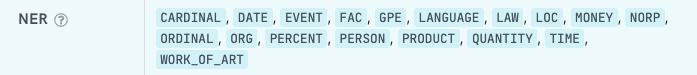

In [12]:
from IPython.display import display
from PIL import Image
display(Image.open("ner_labels.png"))

What do these mean? Can we find a list of class definitions somewhere to better understand what we're being shown?

In [11]:
for label in nlp.get_pipe('ner').labels:
    print(label, '|', spacy.explain(label))

CARDINAL | Numerals that do not fall under another type
DATE | Absolute or relative dates or periods
EVENT | Named hurricanes, battles, wars, sports events, etc.
FAC | Buildings, airports, highways, bridges, etc.
GPE | Countries, cities, states
LANGUAGE | Any named language
LAW | Named documents made into laws.
LOC | Non-GPE locations, mountain ranges, bodies of water
MONEY | Monetary values, including unit
NORP | Nationalities or religious or political groups
ORDINAL | "first", "second", etc.
ORG | Companies, agencies, institutions, etc.
PERCENT | Percentage, including "%"
PERSON | People, including fictional
PRODUCT | Objects, vehicles, foods, etc. (not services)
QUANTITY | Measurements, as of weight or distance
TIME | Times smaller than a day
WORK_OF_ART | Titles of books, songs, etc.


---
Let's explore the first article in the dataset--first, we'll load the article in spaCy format and explore processed spaCy output.

In [20]:
doc = nlp(df1['contents'][0])

`doc` has already calculated everything you might want to know about a text. It's a special `Span` object, that prints like a string, but can iterate over tokens, and so much more.

In [21]:
for token in doc:
    print(token, token.text, token.i, token.idx)
    print(dir(token))
    break# token.i = token index; token.idx = character index

US US 0 0
['_', '__bytes__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__unicode__', 'ancestors', 'check_flag', 'children', 'cluster', 'conjuncts', 'dep', 'dep_', 'doc', 'ent_id', 'ent_id_', 'ent_iob', 'ent_iob_', 'ent_kb_id', 'ent_kb_id_', 'ent_type', 'ent_type_', 'get_extension', 'has_dep', 'has_extension', 'has_head', 'has_morph', 'has_vector', 'head', 'i', 'idx', 'iob_strings', 'is_alpha', 'is_ancestor', 'is_ascii', 'is_bracket', 'is_currency', 'is_digit', 'is_left_punct', 'is_lower', 'is_oov', 'is_punct', 'is_quote', 'is_right_punct', 'is_sent_end', 'is_sent_start', 'is_space', 'is_stop', 'is_title', 'is_upper', 'lang', 'lang_', 'left_edge', 'lefts', 'lemma', 'lemma_', 'lex', 'lex_id', 'like_ema

With the `doc` object, we can take a look at the NER output to see what entities were extracted from the document. Each entity (ent) in `doc.ents` is a `Span` object, which records information such as the text of the entity, label of the entity, associated token indices, and more.

In [22]:
for ent in doc.ents:
    print(ent, ent.text, ent.label_)

US GOVERNMENT TELEPHONE INTERCEPT US GOVERNMENT TELEPHONE INTERCEPT ORG
5 5 CARDINAL
FEBRUARY 2008 FEBRUARY 2008 DATE
Kiev Kiev GPE
Ukraine Ukraine GPE
Tabriz Tabriz GPE
Iran Iran GPE
Kiev Kiev GPE
24 24 CARDINAL
Janbazan St Janbazan St PERSON
West Ajerbaijan West Ajerbaijan GPE
Tabriz Tabriz GPE
Iran Iran GPE
Sattari Khurshid Sattari Khurshid PERSON
Urmia Urmia GPE
the 12th the 12th DATE
Soltan Soltan PERSON


In [23]:
dir(list(doc.ents)[0])

['_',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_fix_dep_copy',
 '_vector',
 '_vector_norm',
 'as_doc',
 'char_span',
 'conjuncts',
 'doc',
 'end',
 'end_char',
 'ent_id',
 'ent_id_',
 'ents',
 'get_extension',
 'get_lca_matrix',
 'has_extension',
 'has_vector',
 'kb_id',
 'kb_id_',
 'label',
 'label_',
 'lefts',
 'lemma_',
 'n_lefts',
 'n_rights',
 'noun_chunks',
 'orth_',
 'remove_extension',
 'rights',
 'root',
 'sent',
 'sentiment',
 'sents',
 'set_extension',
 'similarity',
 'start',
 'start_char',
 'subtree',
 'tensor',
 'text',
 'text_with_ws',
 'to_array',
 'vector',
 'vector_norm',
 'vocab']

Let's go back to token iteration. Remember IOB encoding? The token object keeps track of these labels, separate from the `Span` information.

In [24]:
sents = list(doc.sents)
for token in sents[0]: # Let's just take a look at the first sentence
    print(token, token.ent_iob_, token.ent_type_)

US B ORG
GOVERNMENT I ORG
TELEPHONE I ORG
INTERCEPT I ORG
: O 
5 B CARDINAL
FEBRUARY B DATE
2008 I DATE
< O 
br><br O 
> O 
Call O 
placed O 
from O 
Kiev B GPE
, O 
Ukraine B GPE
to O 
Tabriz B GPE
, O 
Iran B GPE
. O 


Since we're working with NER, we can use displaCy to visualize entities.

In [25]:
spacy.displacy.render(doc, style='ent')

---
We can also use displaCy to display only the PERSON entities.

In [27]:
options={'ents' : ['PERSON','GPE']}
spacy.displacy.render(doc, style='ent', options=options)

###Actual code here

In [33]:
# Load the documents
data_file_1 = 'Documents_Dataset_1.json'
# data_file_2 = 'Documents_Dataset_2.json'
# data_file_3 = 'Documents_Dataset_3.json'

df1 = pd.read_json(data_file_1, orient='records', lines=True)
# df2 = pd.read_json(data_file_2, orient='records', lines=True)
# df3 = pd.read_json(data_file_3, orient='records', lines=True)

In [45]:
doc = nlp(df1['contents'][0])
geo_ents = list({str(word) for word in doc.ents if word.label_=='GPE'})
geo_ents

['Kiev', 'Iran', 'West Ajerbaijan', 'Tabriz', 'Ukraine', 'Urmia']

In [47]:
# Loop through each document to create a list of each Person or GPE in each document as an array
df = df1
documentIDs = []
documentGeos = []
documentPeople = []

for i in range(len(df['contents'])):
    doc = nlp(df1['contents'][i])
    documentIDs.append(df['id'][i])
    documentGeos.append(list({str(word) for word in doc.ents if word.label_=='GPE'}))
    documentPeople.append(list({str(word) for word in doc.ents if word.label_=='PERSON'}))

In [49]:
# Print some checks
len(documentIDs)

102

In [50]:
len(documentGeos)

102

In [51]:
len(documentPeople)

102

In [52]:
documentGeos[0]

['Kiev', 'Iran', 'West Ajerbaijan', 'Tabriz', 'Ukraine', 'Urmia']

In [53]:
documentPeople[0]

['Soltan', 'Janbazan St', 'Sattari Khurshid']

In [58]:
# Make output JSON objects
output = []
for i in range(len(documentIDs)):
    tempObj = {}
    tempObj["id"] = documentIDs[i]
    tempObj["Geos"] = documentGeos[i]
    tempObj["People"] = documentPeople[i]
    output.append(tempObj)
    
outJSON = {}
outJSON['Documents'] = output

In [61]:
type(outJSON)

dict

In [63]:
# Save to file
import json
filename = "Entities_Dataset_1.json"
with open(filename, 'w') as outfile:
    json.dump(outJSON, outfile)

### Drawbacks

Most off-the-shelf (OTS) models such as this one have been trained on "well-formed" or edited text. This usually means these models underperform on text from more colloquial sources with non-standardized capitalization, e.g., social media. You'll also see a lower recall on unseen or rarely-seen entities.  

In [20]:
text1 = 'excited for my trip to seattle!'
text2 = 'excited for my trip to Seattle!'

doc1 = nlp(text1)
doc2 = nlp(text2)

In [21]:
spacy.displacy.render(doc1, style='ent')

/home/ecary/.local/lib/python3.10/site-packages/spacy/displacy/__init__.py:200: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [22]:
spacy.displacy.render(doc2, style='ent')

Bias and fairness issues are present in NER, just as they are throughout AI. Let's take a look at Western/Euro-centric names compared to non-Western names.

In [23]:
text1 = 'john and jessica finished the book together'
text2 = 'ahmed and leila finished the book together'

doc1 = nlp(text1)
doc2 = nlp(text2)

In [24]:
spacy.displacy.render(doc1, style='ent')

In [25]:
spacy.displacy.render(doc2, style='ent')

In [26]:
text1 = 'Sam and Jessica finished the book together.'
text2 = 'Leila and Musu finished the book together and posted their success on Twitter.'
text3 = 'Leila Mansour and N\'Mah Bittar finished the book together and posted their success on twitter.'

doc1 = nlp(text1)
doc2 = nlp(text2)
doc3 = nlp(text3)

In [27]:
spacy.displacy.render(doc1, style='ent')

In [28]:
spacy.displacy.render(doc2, style='ent')

In [29]:
spacy.displacy.render(doc3, style='ent')

### Exercise
Take a look at the named entities available in the sample dataset (all 500 paragraphs). See if you can answer the following questions:

1) What are the 10 most common entities?\
2) What are the 10 most common entities for three (3) types of entities (PERSON, GPE, etc.)?\
3) What are the 10 most common entities if we restrict entity type to PERSON, GPE, LOC, and ORG? 

### Challenge

If we categorize articles by named entities, will we see similar topics or subject matters within a group? What if we used these entities as shorthand for content tags?

What about the "highlights" available for each article? These highlights are brief snippets summarizing the corresponding article. Do you see overlap between the entities within an article and those included in the highlights?

## Coreference Resolution

Let's move on to coreference resolution. Now we're going to take a look at `allennlp`, which offers an OTS coreference resolution model. You'll notice this is a SpanBERT model, which is based on a version of BERT that masks on phrases, or spans, rather than tokens.

You can also check out their demo + visualizer [here](https://demo.allennlp.org/coreference-resolution).

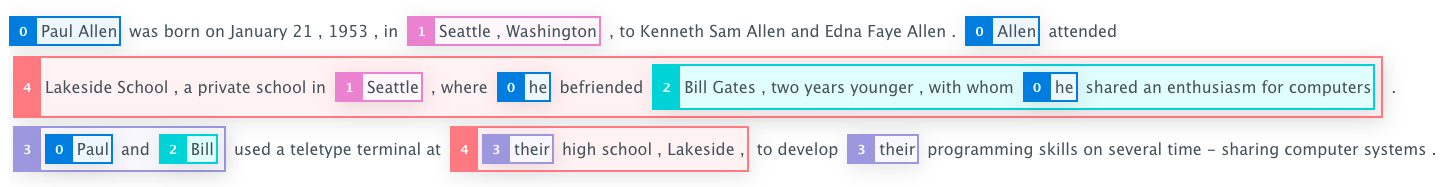

In [30]:
display(Image.open("coref_viz.png"))

Load the model:

In [31]:
from allennlp.predictors.predictor import Predictor
import allennlp_models.tagging

predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2021.03.10.tar.gz")

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# This article was selected because it does have some instances of coreference using both proper nouns and pronouns.
df['article'][3] 

"Frail and tired of leading a secret life for four decades, 66-year-old Clarence David Moore called police this week to surrender. The deputy who answered thought it was a prank. It wasn't. Moore escaped from police custody three times during the 1970s and eventually settled into a quiet life, living in Kentucky since at least 2009. His health is poor from a stroke late last year and he has difficulty speaking."

Potential spans are often noun phrases, including proper nouns and pronouns.

In [33]:
accepted_pos = {'PROPN', 'PRON','NOUN'}
doc = nlp(df['article'][3])
for sent in doc.sents:
    print([(token.text, token.pos_, token.tag_) for token in sent if token.pos_ in accepted_pos])

[('Frail', 'NOUN', 'NN'), ('life', 'NOUN', 'NN'), ('decades', 'NOUN', 'NNS'), ('year', 'NOUN', 'NN'), ('Clarence', 'PROPN', 'NNP'), ('David', 'PROPN', 'NNP'), ('Moore', 'PROPN', 'NNP'), ('police', 'NOUN', 'NNS'), ('week', 'NOUN', 'NN')]
[('deputy', 'NOUN', 'NN'), ('who', 'PRON', 'WP'), ('it', 'PRON', 'PRP'), ('prank', 'NOUN', 'NN')]
[('It', 'PRON', 'PRP')]
[('Moore', 'PROPN', 'NNP'), ('police', 'NOUN', 'NNS'), ('custody', 'NOUN', 'NN'), ('times', 'NOUN', 'NNS'), ('1970s', 'NOUN', 'NNS'), ('life', 'NOUN', 'NN'), ('Kentucky', 'PROPN', 'NNP')]
[('His', 'PRON', 'PRP$'), ('health', 'NOUN', 'NN'), ('stroke', 'NOUN', 'NN'), ('year', 'NOUN', 'NN'), ('he', 'PRON', 'PRP'), ('difficulty', 'NOUN', 'NN')]


In [34]:
for chunk in doc.noun_chunks:
    print(chunk)

a secret life
four decades
66-year-old Clarence David Moore
police
The deputy
who
it
a prank
It
Moore
police custody
the 1970s
a quiet life
Kentucky
His health
a stroke
he
difficulty


In [35]:
output = predictor.predict(
    document=df['article'][3]
)

In [36]:
output.keys()

dict_keys(['top_spans', 'antecedent_indices', 'predicted_antecedents', 'document', 'clusters'])

In [37]:
output

{'top_spans': [[0, 10],
  [4, 4],
  [5, 7],
  [9, 10],
  [12, 19],
  [12, 23],
  [12, 25],
  [20, 20],
  [21, 21],
  [22, 23],
  [25, 25],
  [27, 30],
  [32, 32],
  [33, 33],
  [34, 35],
  [37, 37],
  [39, 39],
  [41, 41],
  [42, 42],
  [44, 45],
  [49, 50],
  [53, 53],
  [55, 57],
  [59, 59],
  [61, 61],
  [65, 65],
  [67, 67],
  [67, 68],
  [72, 73],
  [72, 76],
  [74, 76],
  [78, 78],
  [79, 79]],
 'antecedent_indices': [[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32],
  [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32],
  [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,


Keys of interest included in model output:

| Name | Info |
| :- | :- | 
|top_spans|spans that survived the pruning stage
|predicted_antecedents|predicted antecedent for a given span in 'top_spans'
|document|tokens
|clusters|coreference chains or clusters

Check the AllenNLP [documentation](https://docs.allennlp.org/models/main/models/coref/models/coref/#forward.returns) for more information.

What clusters did the model find?

In [38]:
for cluster in output['clusters']:
    print('*****')
    for span in cluster:
        print(output['document'][span[0]:span[1]+1])

*****
['called']
['it']
['It']
*****
['66', '-', 'year', '-', 'old', 'Clarence', 'David', 'Moore']
['Moore']
['His']
['he']


In [39]:
df['article'][3]

"Frail and tired of leading a secret life for four decades, 66-year-old Clarence David Moore called police this week to surrender. The deputy who answered thought it was a prank. It wasn't. Moore escaped from police custody three times during the 1970s and eventually settled into a quiet life, living in Kentucky since at least 2009. His health is poor from a stroke late last year and he has difficulty speaking."

What would the text look like if we replaced all mentions of the same entity with its original antecedent?

In [40]:
for cluster in output['clusters']:
    text = output['document'].copy()
    delta = 0
    replace_text = text[cluster[0][0]:cluster[0][1]+1]
    for span in cluster:
        text[span[0]] = ' '.join(replace_text)
        text[span[0]+1:span[1]+1] = [''] * (span[1] - span[0])
    print('*****')
    print(' '.join(text))

*****
Frail and tired of leading a secret life for four decades , 66 - year - old Clarence David Moore called police this week to surrender . The deputy who answered thought called was a prank . called was n't . Moore escaped from police custody three times during the 1970s and eventually settled into a quiet life , living in Kentucky since at least 2009 . His health is poor from a stroke late last year and he has difficulty speaking .
*****
Frail and tired of leading a secret life for four decades , 66 - year - old Clarence David Moore        called police this week to surrender . The deputy who answered thought it was a prank . It was n't . 66 - year - old Clarence David Moore escaped from police custody three times during the 1970s and eventually settled into a quiet life , living in Kentucky since at least 2009 . 66 - year - old Clarence David Moore health is poor from a stroke late last year and 66 - year - old Clarence David Moore has difficulty speaking .


### Exercise
Run the coreference resolution and re-run your NER analysis assuming all mentions of a cluster fall under the same discourse entity. (The example article above would have (4) counts of Clarence David Moore instead of (1) count of Clarence David Moore and (1) count of Moore.)

Depending on the size of your EC2 instance, this model can be quite slow to run. If that's the case, pick a small sample of articles to play with.

Are you seeing any new patterns? How about numbers of entities and types of entities? 

### Challenge

If you have time, you can try your hand at creating a graph using something like `networkx`, connecting entities by co-occurrence.

In [ ]:
!{sys.executable} -m pip install networkx

In [ ]:
import networkx as nx

G = nx.Graph()

# Add nodes/edges from entity co-occurrences

### Bonus

spaCy includes support for [creating your own knowledge base and following entity linking](https://spacy.io/usage/linguistic-features#entity-linking) based on a given (or trained) database. A common approach would be to use Wikipedia data for a generic model, but you can add your own unique entities tailored to your use case. For this exercise, try your hand at hard-coding a few entities using spaCy's entity linking feature.

### Final Notes

You might hear `neuralcoref` mentioned as an OTS coreference model, accessible via a pipeline extension for spaCy. We opted not to use it here because it has specific constraints brought about by versioning issues (requires spaCy 2 and python 3.7 or lower). That being said, if you have a flexible dev environment, it can be useful. More information on the wrapped coreference resolution model is available [here](https://spacy.io/universe/project/neuralcoref) and [here](https://github.com/huggingface/neuralcoref). Sample code is available below.

You can also check out their demo visualizer [here](https://huggingface.co/coref/).

*Note: It looks like [spaCy developers are actively working](https://github.com/explosion/spaCy/pull/7264) on incorporating a native coreference module into spaCy 3.*


In [ ]:
!{sys.executable} -m pip install neuralcoref

In [ ]:
import neuralcoref

# Add the neuralcoref module to the existing spaCy model -> only needs to be done once
neuralcoref.add_to_pipe(nlp)

In [ ]:
doc = nlp(df['article'][3])

In [ ]:
doc._.has_coref

In [ ]:
doc._.coref_clusters

In [ ]:
doc._.coref_resolved